# Jpeg Compressor
__Author__ : Mohammad Rouintan , 400222042

__Course__ : Undergraduate Digital Image Processing Course

In [37]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import heapq as hp
from collections import defaultdict

The "blocked_image" function takes an image (represented as a NumPy array) as input, and splits it into 8x8 blocks. It returns a list of these blocks, where each block is also represented as a NumPy array.

The "blocked_image_inverse" function takes a list of 8x8 blocks (also represented as NumPy arrays) and the shape of the original image as input. It then constructs the original image by placing the blocks back in their original positions. The function returns the original image as a NumPy array.

In [38]:
def blocked_image(img):
    num_rows, num_cols = img.shape[:2]
    num_blocks_x = num_cols // 8
    num_blocks_y = num_rows // 8
    
    blocked_img = []
    
    for y in range(num_blocks_y):
        for x in range(num_blocks_x):
            start_x = x * 8
            finish_x = start_x + 8
            
            start_y = y * 8
            finish_y = start_y + 8
            
            block = img[start_y:finish_y, start_x:finish_x]
            blocked_img.append(block)
    
    return blocked_img

def blocked_image_inverse(blocked_img, shape):
    num_rows, num_cols = shape[:2]
    num_blocks_x = num_cols // 8
    num_blocks_y = num_rows // 8
    
    original_image = np.zeros(shape, dtype=np.uint8)
    
    block_index = 0
    for y in range(num_blocks_y):
        for x in range(num_blocks_x):
            start_x = x * 8
            finish_x = start_x + 8
            
            start_y = y * 8
            finish_y = start_y + 8
            
            block = blocked_img[block_index]
            block_index += 1
            
            original_image[start_y:finish_y, start_x:finish_x] = block
    
    return original_image

The "DCT" function takes a list of blocked images (represented as a list of NumPy arrays) as input, and applies the DCT to each block. It returns a list of DCT coefficients, where each element of the list corresponds to one of the input blocks, and is itself a NumPy array of the same shape as the input block.

The "DCT_Inverse" function takes a list of DCT coefficients (also represented as a list of NumPy arrays), and applies the inverse DCT to each coefficient block. It returns a list of reconstructed blocked images, where each element of the list corresponds to one of the input DCT coefficient blocks, and is itself a NumPy array of the same shape as the original input block.

In [39]:
def DCT(blocked_img):
    dcts = []
    for block in blocked_img:
        dct = np.stack([cv2.dct(np.float32(block[:,:,i])) for i in range(block.shape[2])], axis=2)
        dcts.append(dct)
    return dcts

def DCT_Inverse(dct_blocked_img):
    blocked_img = []
    for dct_block in dct_blocked_img:
        block = np.stack([cv2.idct(np.float32(dct_block[:,:,i])) for i in range(dct_block.shape[2])], axis=2)
        blocked_img.append(block)
    return blocked_img

The "quantization" function takes a list of DCT coefficient blocks (represented as a list of NumPy arrays) as input, and applies a quantization matrix to each coefficient block. The quantization matrix is a fixed matrix that defines the amount of quantization applied to each coefficient. The function returns a list of quantized DCT coefficient blocks, where each element of the list corresponds to one of the input blocks, and is itself a NumPy array of the same shape as the input block.

The "dequantization" function takes a list of quantized DCT coefficient blocks (also represented as a list of NumPy arrays), and the quantization matrix used for quantization, and applies the inverse quantization matrix to each coefficient block. It returns a list of reconstructed DCT coefficient blocks, where each element of the list corresponds to one of the input quantized blocks, and is itself a NumPy array of the same shape as the original input block.

In [180]:
def quantization(blocked_img, lossy=1):
    quantization_table = (1 / lossy) * np.array([[16, 11, 10, 16, 24, 40, 51, 61],
                                            [12, 12, 14, 19, 26, 58, 60, 55],
                                            [14, 13, 16, 24, 40, 57, 69, 56],
                                            [14, 17, 22, 29, 51, 87, 80, 62],
                                            [18, 22, 37, 56, 68, 109, 103, 77],
                                            [24, 35, 55, 64, 81, 104, 113, 92],
                                            [49, 64, 78, 87, 103, 121, 120, 101],
                                            [72, 92, 95, 98, 112, 100, 103, 99]])

    quantized_img = []
    for block in blocked_img:
        dct_quantized = np.stack([np.round(block[:,:,i] / quantization_table) for i in range(block.shape[2])], axis=2)
        quantized_img.append(dct_quantized)
    return quantized_img, quantization_table

def dequantization(quantized_img, quantization_table):
    blocked_img = []
    for quantized_block in quantized_img:
        dct_dequantized = np.stack([np.round(quantized_block[:,:,i] * quantization_table) for i in range(quantized_block.shape[2])], axis=2)
        blocked_img.append(dct_dequantized)
    return blocked_img

The "zigzag" function takes a list of blocked images (represented as a list of NumPy arrays) as input and applies the zigzag scanning to each block. Zigzag scanning is a technique used in JPEG image compression to transform the 8x8 DCT coefficient blocks into a 1D array that is more amenable to compression. The function returns a list of zigzag-scanned blocks, where each element of the list corresponds to one of the input blocks, and is itself a NumPy array of shape (64, 3), representing the zigzag-scanned Y, Cr, and Cb components of the block.

The "zigzag_inverse" function takes a list of zigzag-scanned blocks (also represented as a list of NumPy arrays) as input and applies the inverse zigzag scanning to each block. The inverse zigzag scanning reconstructs the 8x8 DCT coefficient blocks from the 1D zigzag array. The function returns a list of reconstructed blocked images, where each element of the list corresponds to one of the input zigzag-scanned blocks, and is itself a NumPy array of shape (8, 8, 3), representing the reconstructed Y, Cr, and Cb components of the block.

In [138]:
def zigzag(blocked_img):
    zigzag_array = np.array([
    [ 0,  1,  5,  6, 14, 15, 27, 28],
    [ 2,  4,  7, 13, 16, 26, 29, 42],
    [ 3,  8, 12, 17, 25, 30, 41, 43],
    [ 9, 11, 18, 24, 31, 40, 44, 53],
    [10, 19, 23, 32, 39, 45, 52, 54],
    [20, 22, 33, 38, 46, 51, 55, 60],
    [21, 34, 37, 47, 50, 56, 59, 61],
    [35, 36, 48, 49, 57, 58, 62, 63]])

    zigzag_blocks = []
    flatten_zigzag = zigzag_array.flatten()
    for block in blocked_img:
        y, cr, cb = block[:,:,0].flatten(), block[:,:,1].flatten(), block[:,:,2].flatten()
        y_ordered = y[flatten_zigzag]
        cb_ordered = cb[flatten_zigzag]
        cr_ordered = cr[flatten_zigzag]
        zigzag_blocks.append(np.stack([y_ordered, cr_ordered, cb_ordered], axis=1))
    return zigzag_blocks

def zigzag_inverse(zigzag_blocks):
    zigzag_array = np.array([
        [ 0,  1,  5,  6, 14, 15, 27, 28],
        [ 2,  4,  7, 13, 16, 26, 29, 42],
        [ 3,  8, 12, 17, 25, 30, 41, 43],
        [ 9, 11, 18, 24, 31, 40, 44, 53],
        [10, 19, 23, 32, 39, 45, 52, 54],
        [20, 22, 33, 38, 46, 51, 55, 60],
        [21, 34, 37, 47, 50, 56, 59, 61],
        [35, 36, 48, 49, 57, 58, 62, 63]])

    blocked_img = []
    flatten_zigzag = zigzag_array.flatten()
    for block in zigzag_blocks:
        y_ordered, cr_ordered, cb_ordered = block[:,0], block[:,1], block[:,2]
        y = np.zeros((64,))
        cb = np.zeros((64,))
        cr = np.zeros((64,))
        y[flatten_zigzag] = y_ordered
        cb[flatten_zigzag] = cb_ordered
        cr[flatten_zigzag] = cr_ordered
        y = np.reshape(y, (8, 8))
        cb = np.reshape(cb, (8, 8))
        cr = np.reshape(cr, (8, 8))
        block = np.stack([y, cr, cb], axis=2)
        blocked_img.append(block)
    return blocked_img

The "huffman_encode" function takes an input array and calculates the frequency of each element in the array. It then constructs a Huffman tree based on the frequency of each element, and generates a dictionary of Huffman codes for each element. The function returns the Huffman-encoded array as a string of binary digits, along with the dictionary of Huffman codes.

The "huffman_decode" function takes the Huffman-encoded array and the dictionary of Huffman codes as input and decodes the array back to the original array of elements. The function generates an inverse dictionary of Huffman codes to facilitate decoding, and iteratively reads bits from the encoded array, decoding them using the inverse dictionary until the entire array is decoded.

In [42]:
def huffman_encode(arr):
    freq = defaultdict(int)
    for num in arr:
        freq[num] += 1
    
    heap = [[wt, [sym, ""]] for sym, wt in freq.items()]
    hp.heapify(heap)
    while len(heap) > 1:
        low = hp.heappop(heap)
        high = hp.heappop(heap)
        for pair in low[1:]:
            pair[1] = '0' + pair[1]
        for pair in high[1:]:
            pair[1] = '1' + pair[1]
        hp.heappush(heap, [low[0] + high[0]] + low[1:] + high[1:])

    huffman_codes = dict(hp.heappop(heap)[1:])
    encoded_array = ""
    for num in arr:
        encoded_array += huffman_codes[num]
    
    return encoded_array, huffman_codes

def huffman_decode(encoded_array, huffman_codes):
    inverse_huffman_codes = {v: k for k, v in huffman_codes.items()}
    if encoded_array == "":
        return np.zeros(64)

    decoded_array = []
    code = ""
    for bit in encoded_array:
        code += bit
        if code in inverse_huffman_codes:
            decoded_array.append(inverse_huffman_codes[code])
            code = ""
    
    return np.array(decoded_array)

The "matrix_huffman_encode" function takes a 2D input matrix and encodes each column of the matrix using the Huffman encoding technique. It returns a list of the encoded sections, where each section corresponds to one column of the input matrix, and a list of code dictionaries, where each dictionary contains the Huffman codes for the corresponding column of the input matrix.

The "matrix_huffman_decode" function takes a list of encoded sections and a list of code dictionaries as input and decodes each section using the corresponding code dictionary. It returns a 2D matrix where each column corresponds to one of the decoded sections.

In [43]:
def matrix_huffman_encode(matrix):
    encoded_sections = []
    code_dicts = []

    for i in range(matrix.shape[1]):
        array = matrix[:,i]
        encoded_array, code_dict = huffman_encode(array)

        encoded_sections.append(encoded_array)
        code_dicts.append(code_dict)
    
    return encoded_sections, code_dicts

def matrix_huffman_decode(encoded_sections, code_dicts):
    decoded_matrix = np.zeros((64, len(encoded_sections)), dtype=np.uint8)

    for i in range(len(encoded_sections)):
        decoded_array = huffman_decode(encoded_sections[i], code_dicts[i])
        decoded_matrix[:,i] = decoded_array

    return decoded_matrix

The "encode" function takes a list of blocked images as input and encodes each block using the "matrix_huffman_encode" function. It returns a list of Huffman-encoded image blocks, where each block is represented as a list of encoded sections, and a list of code dictionaries, where each dictionary contains the Huffman codes for the corresponding block.

The "decode" function takes a list of Huffman-encoded image blocks and a list of code dictionaries as input and decodes each block using the "matrix_huffman_decode" function. It returns a list of decoded image blocks.

In [44]:
def encode(blocked_img):
    encoded_img, list_code_dicts = [],[]
    for block in blocked_img :
        encoded_sections, code_dict = matrix_huffman_encode(block)
        encoded_img.append(encoded_sections)
        list_code_dicts.append(code_dict)
    return encoded_img, list_code_dicts

def decode(encoded_img, list_code_dict):
    decoded_img = []

    for encoded_sections, code_dict in zip(encoded_img, list_code_dict):
        
        block = matrix_huffman_decode(encoded_sections, code_dict)
        decoded_img.append(block)
        
    return decoded_img

In [190]:
import sys

def process(imgPath):
    # Read Image
    img = cv2.imread(imgPath)

    # Convert to YCrCb
    img_ycrcb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)

    # Normalize Image
    normalized = img_ycrcb - (128,128,128)

    # Blocked Image
    blocked_img = blocked_image(normalized)

    # DCT
    dct = DCT(blocked_img)

    # Quantization
    quantized, quantization_table = quantization(dct, lossy=0.05)
        
    # Zigzag
    zigzaged = zigzag(quantized)

    # Encoding
    encoded_img, code_dict = encode(zigzaged)
    
    # Calculate size
    compressed_img_size = sys.getsizeof(encoded_img) + sys.getsizeof(code_dict)
    original_img_size = sys.getsizeof(img)

    print('Original Image Size:', original_img_size)
    print('Compressed Image Size:', compressed_img_size)
    print('Compression Ratio:', original_img_size / compressed_img_size)
    print('Data Redundancy:', 100 * (1 - 1 / (original_img_size / compressed_img_size)))
    
    # Decoding
    decoded_img = decode(encoded_img, code_dict)
    
    # Zigzag Inverse
    img_zigzag_inverse = zigzag_inverse(decoded_img)

    # Dequantization
    img_deq = dequantization(img_zigzag_inverse, quantization_table)

    # DCT Inverse
    img_idct = DCT_Inverse(img_deq)

    # Blocked Image Inverse
    img_reconstruct = blocked_image_inverse(img_idct, img.shape)

    # Normalized inverse and reconstruct ycrcb image
    img_reconstruct_ycrcb = img_reconstruct + (128,128,128)

    # Change Type
    img_reconstruct_ycrcb = img_reconstruct_ycrcb.astype(np.uint8)

    # Change Color Space
    img_reconstructed = cv2.cvtColor(img_reconstruct_ycrcb, cv2.COLOR_YCrCb2RGB)

    return img_reconstructed

Original Image Size: 59885712
Compressed Image Size: 5203120
Compression Ratio: 11.509577330524762
Data Redundancy: 91.31158363784671


/var/folders/9y/vw5physn1xj4wpb41wh0q6gh0000gn/T/ipykernel_61778/2869212970.py:40: RuntimeWarning: invalid value encountered in cast
  original_image[start_y:finish_y, start_x:finish_x] = block


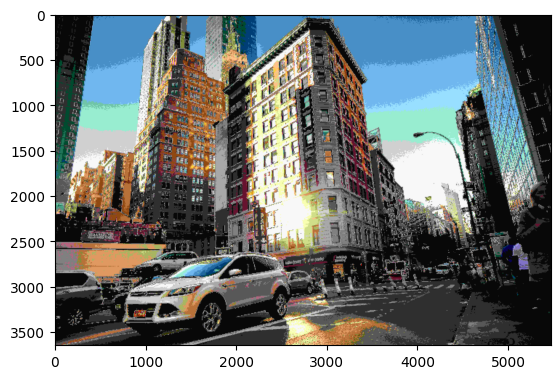

In [191]:
img1_rec = process('Images/img1.jpg')
plt.imshow(img1_rec)
plt.show()

Original Image Size: 49653936
Compressed Image Size: 4624944
Compression Ratio: 10.736116156217243
Data Redundancy: 90.68564473922068


/var/folders/9y/vw5physn1xj4wpb41wh0q6gh0000gn/T/ipykernel_61778/2869212970.py:40: RuntimeWarning: invalid value encountered in cast
  original_image[start_y:finish_y, start_x:finish_x] = block


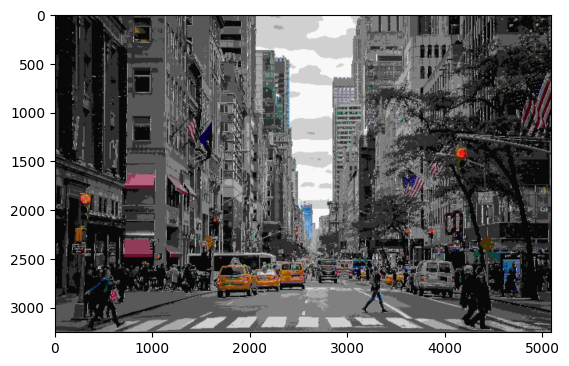

In [192]:
img2_rec = process('Images/img2.jpg')
plt.imshow(img2_rec)
plt.show()